In [4]:
import os
import ee
import geemap
import geemap.chart as chart
from geemap import cartoee
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import ipygee as ui
from skimage.filters import threshold_otsu
from skimage.filters import threshold_li
from skimage.filters import threshold_local
from collections import namedtuple
import time

import warnings
warnings.filterwarnings('ignore')

In [5]:
import skimage.io
import skimage.color
import skimage.filters

In [6]:
# Get basemap layer and set it to Addis Ababa
map = geemap.Map(center=(8.9801, 38.7805), zoom=11)
map

Map(center=[8.9801, 38.7805], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chil…

In [16]:
# Set area of interest within Addis Ababa
aoi = ee.FeatureCollection(map.draw_features)

In [17]:
# Data required
LS_8 = "LANDSAT/LC08/C02/T1_L2"
LS_7 = "LANDSAT/LE07/C02/T1_L2"
LS_5 = "LANDSAT/LT05/C02/T1_L2"

# # Set date filters
start = ee.Date('1991-01-01')
date_today = datetime.date.today().strftime('%Y-%m-%d')
end = ee.Date(date_today)

# Set additional filters 
cloud = ee.Filter.lt("CLOUD_COVER", 5)
season = ee.Filter.calendarRange(10, 2, 'month')
order = "system:time_start"

# Filter the collection
def filter_cltn(cltn, aoi, cloud, startDate, endDate, season, order):
    return ee.ImageCollection(cltn)\
    .filterBounds(aoi)\
    .filter(cloud)\
    .filterDate(startDate, endDate)\
    .filter(season)\
    .sort(order)\
    .map(lambda image: image.clip(aoi))

In [18]:
# Code obtained from a combination of 
# https://github.com/giswqs/geemap/blob/ca365d23a10dbbbb29ff3ff5cd29acc89f42d10f/geemap/timelapse.py#L2075
# and https://gist.github.com/jdbcode/76b9ac49faf51627ebd3ff988e10adbc

### Function to mask out clouds and apply scaling factors
def fmask(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)    

    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True).addBands(thermalBands, None, True).updateMask(qaMask)


### Function to rename Landsat 5 and 7 bands. 
def Bands_L5_L7(L5_L7imgs):
    return L5_L7imgs.select(
        ["SR_B1", "SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B7"],
        ["Blue", "Green", "Red", "NIR", "SWIR1", "SWIR2"],
    )


### Function to rename Landsat 5 and 7 bands. 
def Bands_L8(L8imgs):
    return L8imgs.select(
        ["SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B6", "SR_B7"],
        ["Blue", "Green", "Red", "NIR", "SWIR1", "SWIR2"],
    )

### Functions to prepare and resample Landsat 5, 7 and 8 imagery.
def prepL8(img):
    orig = img
    img = fmask(img)
    img = Bands_L8(img)
    return ee.Image(img.copyProperties(orig, orig.propertyNames())).resample("bicubic")

def prep_L5L7(img):
    orig = img
    img = fmask(img)
    img = Bands_L5_L7(img)
    return ee.Image(img.copyProperties(orig, orig.propertyNames())).resample("bicubic")

In [19]:
# Include the following indices - Normalized difference built-up index (NDBI), 
# Normalized Difference Thermal Index (NDTI) and Buildup Index (BUI)

def indices(img):
    
    # calculate ndbi
    ndbi = img.normalizedDifference(["SWIR1", "NIR"]).rename('NDBI')
    
    # calculate mndbi
    mndbi = img.normalizedDifference(["SWIR2", "Blue"]).rename('MNDBI')
    
    
    buiA = img.expression("(SWIR1 - NIR) / (SWIR1 + NIR)", {
        "SWIR1": img.select("SWIR1"),
        "NIR": img.select("NIR")
    }).rename("BUI_A")
    
    buiB = img.expression("(NIR - Red) / (NIR + Red)", {
        "NIR": img.select("NIR"),
        "Red": img.select("Red")
    }).rename("BUI_B")
        
    bui_AB = buiA.addBands(buiB);
    bui = bui_AB.normalizedDifference(["BUI_A", "BUI_B"]).rename("BUI")
    
    #Calculate Index-Based Built-Up Index (IBI)
    # https://bikeshbade.com.np/tutorials/Detail/?title=Most%20used%20spectral%20Indices%20with%20free%20satellite%20data&code=23
    ibiA = img.expression('2 * SWIR1 / (SWIR1 + NIR)', {
        'SWIR1': img.select('SWIR1'),
        'NIR'  : img.select('NIR')}).rename("IBI_A")
    
    ibiB = img.expression('(NIR / (NIR + Red)) + (Green / (Green + SWIR1))', {
        "NIR"  : img.select("NIR"),
        "Red"  : img.select("Red"),
        "Green": img.select("Green"),
        "SWIR1": img.select("SWIR1")}).rename("IBI_B")
    
    ibiAB = ibiA.addBands(ibiB);
    ibi = ibiAB.normalizedDifference(["IBI_A", "IBI_B"]).rename("IBI")
    
    
    # Calculate ENDISI - https://docs.dea.ga.gov.au/notebooks/Real_world_examples/Urban_change_detection.html
    swir_diff = img.expression("SWIR1 / SWIR2", {"SWIR1": img.select("SWIR1"), "SWIR2": img.select("SWIR2"),
                                                }).rename('swir_diff')
    
     
    mndwi = img.normalizedDifference(["Green", "SWIR1"]).rename('MNDWI')
 
    img = img.addBands([swir_diff, mndwi])
    
    blue_mean = img.select("Blue").reduceRegion(ee.Reducer.mean(), aoi, 30).toImage().rename("blue_mean")
    
    swir_mean = img.select("swir_diff").reduceRegion(ee.Reducer.mean(), aoi, 30).toImage().rename("swir_mean")
    
    mndwi_mean = img.select("MNDWI").multiply(img.select("MNDWI")).reduceRegion(ee.Reducer.mean(), aoi, 30).toImage().rename("mndwi_mean")
    
    img = img.addBands([blue_mean, swir_mean, mndwi_mean])
    
    alpha = img.expression('(2 * b("blue_mean")) / (b("swir_mean") +  b("mndwi_mean"))').rename("alpha")
    
    img = img.addBands(alpha)
    
    ENDISI = img.expression('(b("Blue") - b("alpha") * (b("swir_diff") + b("MNDWI")**2)) / (b("Blue") + b("alpha") * (b("swir_diff") + b("MNDWI")**2))').rename("ENDISI")
    
    return  img.addBands([ndbi, mndbi, bui, ibi, ENDISI])

In [20]:
### Adapted code from https://gist.github.com/jdbcode/76b9ac49faf51627ebd3ff988e10adbc

# Setup vars to get dates.
startYear = 1991
endYear = 2021
startMonth = 10
startDay = 1
nDays = 151

# Get annual median collection.    
def getAnnualComp(y):
    startDate = ee.Date.fromYMD(
    ee.Number(y), ee.Number(startMonth), ee.Number(startDay))
    endDate = startDate.advance(ee.Number(nDays), 'day')

    # Filter collections and prepare them for merging.
    t_LC08coly = filter_cltn(LS_8, aoi, cloud, startDate, endDate, season, order).map(prepL8)
    t_LE07coly = filter_cltn(LS_7, aoi, cloud, startDate, endDate, season, order).map(prep_L5L7)
    t_LT05coly = filter_cltn(LS_5, aoi, cloud, startDate, endDate, season, order).map(prep_L5L7)

    # Merge the collections.
    col = t_LC08coly.merge(t_LE07coly).merge(t_LT05coly)
    
    yearImg = col.median()
    nBands = yearImg.bandNames().size()
    yearImg = ee.Image(ee.Algorithms.If(
        nBands,
        yearImg,
        dummyImg))
    return(indices(yearImg)
           .set({'year': y, 'system:time_start': startDate.millis(), 'nBands': nBands}))

# # Make a dummy image for missing years.
bandNames = ee.List(['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2'])
fillerValues = ee.List.repeat(0, bandNames.size())
dummyImg = ee.Image.constant(fillerValues).rename(bandNames).selfMask().int16()

# Get a list of years
years = ee.List.sequence(startYear, endYear)

# Make list of annual image composites.
imgList = years.map(getAnnualComp)

# Convert image composite list to collection
imgCol = ee.ImageCollection.fromImages(imgList)

In [21]:
# get the size of the collection
size = imgCol.size().getInfo()

In [22]:
y_1991 = ee.Image(imgList.get(0))
y_1992 = ee.Image(imgList.get(1))
y_1993 = ee.Image(imgList.get(2))
y_1994 = ee.Image(imgList.get(3))
y_1995 = ee.Image(imgList.get(4))
y_1996 = ee.Image(imgList.get(5))

y_1998 = ee.Image(imgList.get(7))
y_1999 = ee.Image(imgList.get(8))
y_2000 = ee.Image(imgList.get(9))
y_2001 = ee.Image(imgList.get(10))
y_2002 = ee.Image(imgList.get(11))
y_2003 = ee.Image(imgList.get(12))
y_2004 = ee.Image(imgList.get(13))
y_2005 = ee.Image(imgList.get(14))
y_2006 = ee.Image(imgList.get(15))
y_2007 = ee.Image(imgList.get(16))
y_2008 = ee.Image(imgList.get(17))
y_2009 = ee.Image(imgList.get(18))
y_2010 = ee.Image(imgList.get(19))
y_2011 = ee.Image(imgList.get(20))
y_2012 = ee.Image(imgList.get(21))
y_2013 = ee.Image(imgList.get(22))
y_2014 = ee.Image(imgList.get(23))
y_2015 = ee.Image(imgList.get(24))
y_2016 = ee.Image(imgList.get(25))
y_2017 = ee.Image(imgList.get(26))
y_2018 = ee.Image(imgList.get(27))
y_2019 = ee.Image(imgList.get(28))
y_2020 = ee.Image(imgList.get(29))
y_2021 = ee.Image(imgList.get(30)) 

annual_list = [y_1991, y_1992, y_1993, y_1994, y_1995, y_1996, y_1998, y_1999, y_2000, y_2001, y_2002, y_2003, y_2004, y_2005, 
               y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019,
              y_2020, y_2021]

In [23]:
# code obtained from 
# https://github.com/mvpeppa/Remote-Sensing-Tests-with-Google-Earth-Engine/blob/main/Waterline%20extraction%20e.g.%20Lake%20Koka%20Ethiopia.ipynb

def img2array1D(img, band):
    # extract the data from an ee.image
    img = img.select(band)
    # extract the pixel values from the image
    info = img.reduceRegion(ee.Reducer.toList(), geometry=aoi, scale=30)
    # Convert to an 1D array for further use
    data = np.array((ee.Array(info.get(band)).getInfo()))
    return data

In [24]:
annual_list = [y_1991, y_1992, y_1993, y_1994, y_1995, y_1996, y_1998, y_1999, y_2000, y_2001, y_2002, y_2003, y_2004, 
               y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, 
               y_2018, y_2019, y_2020, y_2021]

annual_list_names = ["y_1991", "y_1992", "y_1993", "y_1994", "y_1995", "y_1996", "y_1998", "y_1999", "y_2000", "y_2001", 
                     "y_2002", "y_2003", "y_2004", "y_2005", "y_2006", "y_2007", "y_2008", "y_2009", "y_2010", "y_2011", 
                     "y_2012", "y_2013", "y_2014", "y_2015", "y_2016", "y_2017", "y_2018", "y_2019", "y_2020", "y_2021"]

list_of_bands = ["Blue", "Green", "Red", "NIR", "SWIR1", "SWIR2", "NDBI", "MNDBI", "IBI", "ENDISI"]

year_output = []

for _,year in enumerate(annual_list):
    output = []
    
    for _,band in enumerate(list_of_bands):
        output.append(img2array1D(year, band))
    
    year_output.append(dict(zip(list_of_bands, output)))

array_dict = dict(zip(annual_list_names, year_output))

# pd.DataFrame(output_dict)

In [25]:
array_2015 = array_dict["y_2015"]
array_2015

{'Blue': array([0.05656281, 0.07335183, 0.10266929, ..., 0.03066969, 0.02042802,
        0.01904127]),
 'Green': array([0.07986253, 0.095963  , 0.13190408, ..., 0.05190257, 0.03629253,
        0.03510176]),
 'Red': array([0.08776178, 0.10790782, 0.14886654, ..., 0.05435745, 0.0345065 ,
        0.03275639]),
 'NIR': array([0.19221208, 0.19972588, 0.19690574, ..., 0.20421439, 0.19078795,
        0.19072679]),
 'SWIR1': array([0.15086064, 0.18953286, 0.226528  , ..., 0.12246421, 0.07756891,
        0.08097237]),
 'SWIR2': array([0.12215311, 0.16337419, 0.2138945 , ..., 0.07769556, 0.03962648,
        0.04102152]),
 'NDBI': array([-0.12053256, -0.02618574,  0.06995725, ..., -0.2502465 ,
        -0.42189732, -0.4039557 ]),
 'MNDBI': array([0.36700875, 0.38028082, 0.35135162, ..., 0.43395707, 0.31968391,
        0.36595455]),
 'IBI': array([-0.08012392, -0.0058933 ,  0.06599878, ..., -0.18380623,
        -0.336918  , -0.31953767]),
 'ENDISI': array([-3.62916259e-01, -2.22552565e-01, -2.39981

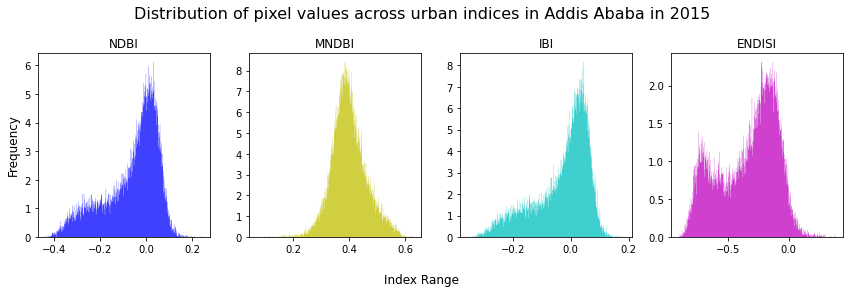

In [26]:
# plot 2015 band histograms
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12,4))

axs[0].hist(array_2015["NDBI"], 500, density=True, histtype='stepfilled', facecolor='b', alpha=0.75)
axs[0].set_title('NDBI')

axs[1].hist(array_2015["MNDBI"], 500, density=True, histtype='stepfilled', facecolor='y', alpha=0.75)
axs[1].set_title('MNDBI')

axs[2].hist(array_2015["IBI"], 500, density=True, histtype='stepfilled', facecolor='c', alpha=0.75)
axs[2].set_title('IBI')

axs[3].hist(array_2015["ENDISI"], 500, density=True, histtype='stepfilled', facecolor='m', alpha=0.75)
axs[3].set_title('ENDISI')

fig.suptitle("Distribution of pixel values across urban indices in Addis Ababa in 2015", size=16)
fig.subplots_adjust(top=0.88)
fig.supxlabel("Index Range")
fig.supylabel("Frequency")

fig.tight_layout()
plt.show()

In [27]:
# Get automiatic thresholds for 2015 (based on Global Human Settlement Data validation)
ndbi_2015otsu = threshold_otsu(array_2015["NDBI"]).round(2)
ndbi_2015li = threshold_li(array_2015["NDBI"]).round(2)

mndbi_2015otsu = threshold_otsu(array_2015["MNDBI"]).round(2)
mndbi_2015li = threshold_li(array_2015["MNDBI"]).round(2)

ibi_2015otsu = threshold_otsu(array_2015["IBI"]).round(2)
ibi_2015li = threshold_li(array_2015["IBI"]).round(2)

endisi_2015otsu = threshold_otsu(array_2015["ENDISI"]).round(2)
endisi_2015li = threshold_li(array_2015["ENDISI"]).round(2)

print(f"Threshold Otsu: NDBI:{ndbi_2015otsu}, MNDBI:{mndbi_2015otsu}, IBI:{ibi_2015otsu}, ENDISI:{endisi_2015otsu}")
print(f"Threshold Li: NDBI:{ndbi_2015li}, MNDBI:{mndbi_2015li}, IBI:{ibi_2015li}, ENDISI:{endisi_2015li}")

Threshold Otsu: NDBI:-0.11, MNDBI:0.41, IBI:-0.07, ENDISI:-0.4
Threshold Li: NDBI:-0.14, MNDBI:0.4, IBI:-0.09, ENDISI:-0.46


Text(0.5, 0.01, 'Index Range')

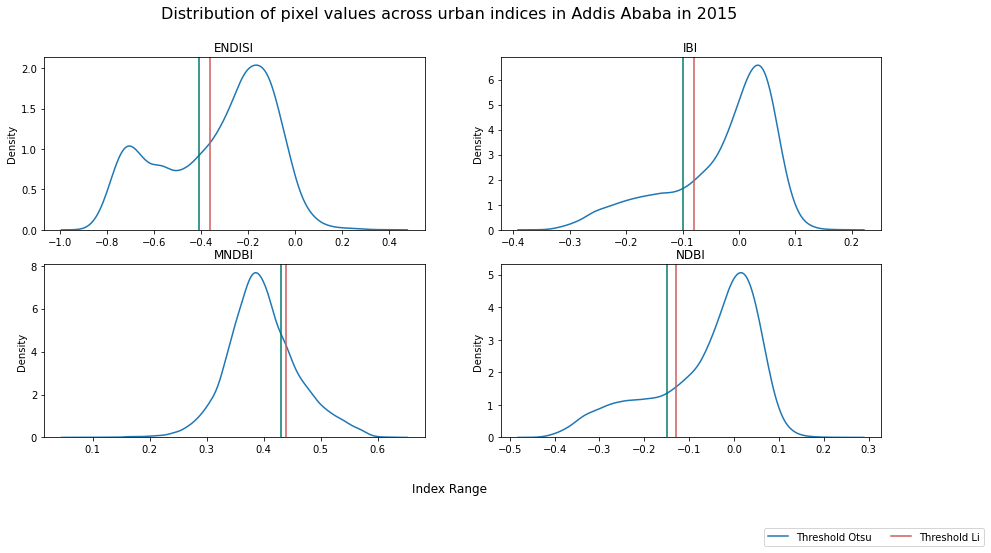

In [28]:
# Plot thresholds

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,7))

sns.kdeplot(array_2015["ENDISI"].flatten(), label='ENDISI',legend=True, ax=ax[0,0])
ax[0,0].axvline(-0.36, color='indianred', label='Threshold Otsu')
ax[0,0].axvline(-0.41, color='#01796f', label='Threshold Li')
ax[0,0].set_title('ENDISI')

sns.kdeplot(array_2015["IBI"].flatten(), label='IBI',legend=True, ax=ax[0,1])
ax[0,1].axvline(-0.08, color='indianred', label='Threshold Otsu')
ax[0,1].axvline(-0.1, color='#01796f', label='Threshold Li')
ax[0,1].set_title('IBI')

sns.kdeplot(array_2015["MNDBI"].flatten(), label='MNDBI',legend=True, ax=ax[1,0])
ax[1,0].axvline(0.44, color='indianred', label='Threshold Otsu')
ax[1,0].axvline(0.43, color='#01796f', label='Threshold Li')
ax[1,0].set_title('MNDBI')

sns.kdeplot(array_2015["NDBI"].flatten(), label='NDBI',legend=True, ax=ax[1,1])
ax[1,1].axvline(-0.13, color='indianred', label='Threshold Otsu')
ax[1,1].axvline(-0.15, color='#01796f', label='Threshold Li')
ax[1,1].set_title('NDBI')

labels = ['Threshold Otsu', 'Threshold Li']
fig.legend(labels, loc='lower right', bbox_to_anchor=(1,-0.1), ncol=len(labels), bbox_transform=fig.transFigure)

fig.suptitle("Distribution of pixel values across urban indices in Addis Ababa in 2015", size=16)
fig.subplots_adjust(top=0.88)
fig.supxlabel("Index Range")

In [29]:
# Get validation data
ghsl_img = ee.Image('JRC/GHSL/P2016/BUILT_LDSMT_GLOBE_V1').select("built").clip(aoi)

In [30]:
# reproject to Landsat
LS_projection = y_2015.projection().getInfo()['crs']
old_scale = ghsl_img.projection().nominalScale().getInfo()
ghsl = ghsl_img.resample('bicubic').reproject(crs=LS_projection, scale=30)
new_scale = ghsl.projection().nominalScale().getInfo()

print(f"Original GHSL scale: {old_scale}, Reprojected Scale: {new_scale}")

Original GHSL scale: 38.218514142588525, Reprojected Scale: 30.000000000000004


In [31]:
ghsl_array = img2array1D(ghsl, "built")

In [32]:
# ghsl_built = ghsl.gte(3)
Params = {"min":0, "max":6, "palette":['0c1d60', '000000','448564', '70daa4', '83ffbf', 'ffffff']}
map.addLayer(ghsl_img, Params, "GHSL/2016")

In [33]:
endisi2015 = y_2015.select("ENDISI").gte(-0.36)
visuals = {"palette": ["black", "orange"]}
map.addLayer(endisi2015, visuals, "ENDISI AT")

In [34]:
endisi2015 = y_2015.select("ENDISI").gte(-0.12)
visuals = {"palette": ["black", "orange"]}
map.addLayer(endisi2015, visuals, "ENDISI MT")